<a href="https://colab.research.google.com/github/ddovidovich/DataScienceLerning/blob/main/UNIT_17_DZ_Ultra_Pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Добро пожаловать на задание уровня Ultra Pro.

В данном задании требуется на базе клеток сделать задачу сегментации с вниманием.

Хотелось бы отметить что данное задание является сложным и Вам потребуется самостоятельно разобраться как правильно включить блок внимания в задачу сегментации.


Успехов!

In [1]:
# Загрузить библиотеку OpenCV для загрузки файлов
import cv2

# Загрузить библиотеку OS для работы с файлами
import os

# Загрузим библиотеку Numpy
import numpy as np

# # Импортируем модель для загрузки файлов
from glob import glob

# 
from matplotlib import pylab as plt

# Импортируем слои
from keras.layers import Conv2D, BatchNormalization, Activation, Dropout, UpSampling2D, Add, Multiply, Input, Concatenate, MaxPooling2D, Conv2DTranspose, multiply

# Импортируем Model
from keras.models import Model

#
from tensorflow.keras.utils import plot_model

# Импортируем оптимизатор
from tensorflow.keras.optimizers import Adam

# функция подсчета ошибки
from keras.losses import binary_crossentropy

# Импортируем backend keras
from keras import backend as K

# для загрузки данных с сети
import gdown

In [2]:
# Подключаем диск
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/advanced/l4/cellbase.zip', None, quiet=True)

'cellbase.zip'

In [3]:
# Распаковываем zip-файл базы
!unzip -o 'cellbase.zip'

Archive:  cellbase.zip
  inflating: label/0.tif             
  inflating: label/1.tif             
  inflating: label/10.tif            
  inflating: label/11.tif            
  inflating: label/12.tif            
  inflating: label/13.tif            
  inflating: label/14.tif            
  inflating: label/15.tif            
  inflating: label/16.tif            
  inflating: label/17.tif            
  inflating: label/18.tif            
  inflating: label/19.tif            
  inflating: label/2.tif             
  inflating: label/20.tif            
  inflating: label/21.tif            
  inflating: label/22.tif            
  inflating: label/23.tif            
  inflating: label/24.tif            
  inflating: label/25.tif            
  inflating: label/26.tif            
  inflating: label/27.tif            
  inflating: label/28.tif            
  inflating: label/29.tif            
  inflating: label/3.tif             
  inflating: label/4.tif             
  inflating: label/5.tif   

In [4]:
def load_data(train_folder, labels_folder):
    train_images = []
    train_labels = []

    # Получаем лист имен файлов из дирректорий
    train_files = os.listdir(train_folder)
    labels_files = os.listdir(labels_folder)

    # сортируем имена файлов, для того чтобы не перепутались тестовые картинки и готовая сегментация
    train_files.sort()
    labels_files.sort()

    # цикл для каждой картинки и сегментации
    for i, (train_file, labels_file) in enumerate(zip(train_files, labels_files)):
        # загрузка картинки
        train_path = os.path.join(train_folder, train_file)
        train_image = cv2.imread(train_path, cv2.IMREAD_GRAYSCALE)
        
        # загрузка сегментации
        labels_path = os.path.join(labels_folder, labels_file)
        labels_image = cv2.imread(labels_path, cv2.IMREAD_GRAYSCALE)

        # нормализация
        train_image = train_image / 255.0
        labels_image = labels_image / 255.0

        # решейп картинки (512, 512, 1)
        train_image = cv2.resize(train_image, (512, 512))
        train_image = np.reshape(train_image, (512, 512, 1))
        
        labels_image = cv2.resize(labels_image, (512, 512))
        labels_image = np.reshape(labels_image, (512, 512, 1))

        # добавляем картинки в соответствующий лист
        train_images.append(train_image)
        train_labels.append(labels_image)

    # конвертируем картинки в numpy arrays
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)

    return train_images, train_labels

In [5]:
def load_test(test_folder):
    test_images = []

    test_files = os.listdir(test_folder)

    test_files.sort()

    for i, test_file in enumerate(test_files):
        test_path = os.path.join(test_folder, test_file)
        test_image = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)
        
        test_image = test_image / 255.0

        test_image = cv2.resize(test_image, (512, 512))
        test_image = np.reshape(test_image, (512, 512, 1))
        
        test_images.append(test_image)

    test_images = np.array(test_images)

    return test_images

In [6]:
path_train = '/content/train/'
path_label = '/content/label/'
train_images, train_labels = load_data(path_train, path_label)

In [7]:
path_test = '/content/test/'
test_images = load_test(path_test)

In [8]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)

(30, 512, 512, 1)
(30, 512, 512, 1)
(30, 512, 512, 1)


In [9]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# Создаем объект ImageDataGenerator с нужными параметрами
data_gen_args = dict(horizontal_flip=True,
                     zoom_range=0.2)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Применяем трансформации к изображениям
seed = 1

# Разделяем данные на обучающий и проверочный наборы
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Создаем генераторы для обучающих и проверочных данных
train_image_generator = image_datagen.flow(train_images, batch_size=1, seed=seed)
train_mask_generator = mask_datagen.flow(train_labels, batch_size=1, seed=seed)
val_image_generator = image_datagen.flow(val_images, batch_size=1, seed=seed)
val_mask_generator = mask_datagen.flow(val_labels, batch_size=1, seed=seed)

# Объединяем генераторы для обучающих и проверочных данных
train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)

In [10]:
def attention_block(inputs, skip_connection, filters):
    x = Concatenate()([inputs, skip_connection])
    x = BatchNormalization()(x)
    x = Conv2D(filters=filters, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=filters, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=filters, kernel_size=(1,1), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=filters, kernel_size=(1,1), activation='sigmoid', padding='same')(x)
    x = multiply([inputs, x])
    return x

In [11]:
def build_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Decoder
    up4 = UpSampling2D(size=(2, 2))(pool3)
    att4 = attention_block(conv3, up4, 256)
    up4 = Concatenate()([up4, att4])
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(up4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    
    up5 = UpSampling2D(size=(2, 2))(conv4)
    att5 = attention_block(conv2, up5, 128)
    up5 = Concatenate()([up5, att5])
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(up5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up6 = UpSampling2D(size=(2, 2))(conv5)
    att6 = attention_block(conv1, up6, 64)
    up6 = Concatenate()([up6, att6])
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    # Output
    output_layer = Conv2D(1, (1,1), activation='sigmoid', padding='same')(conv6)
    model = Model(inputs=[inputs], outputs=[output_layer])
    return model

In [12]:
model = build_model((512, 512, 1))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

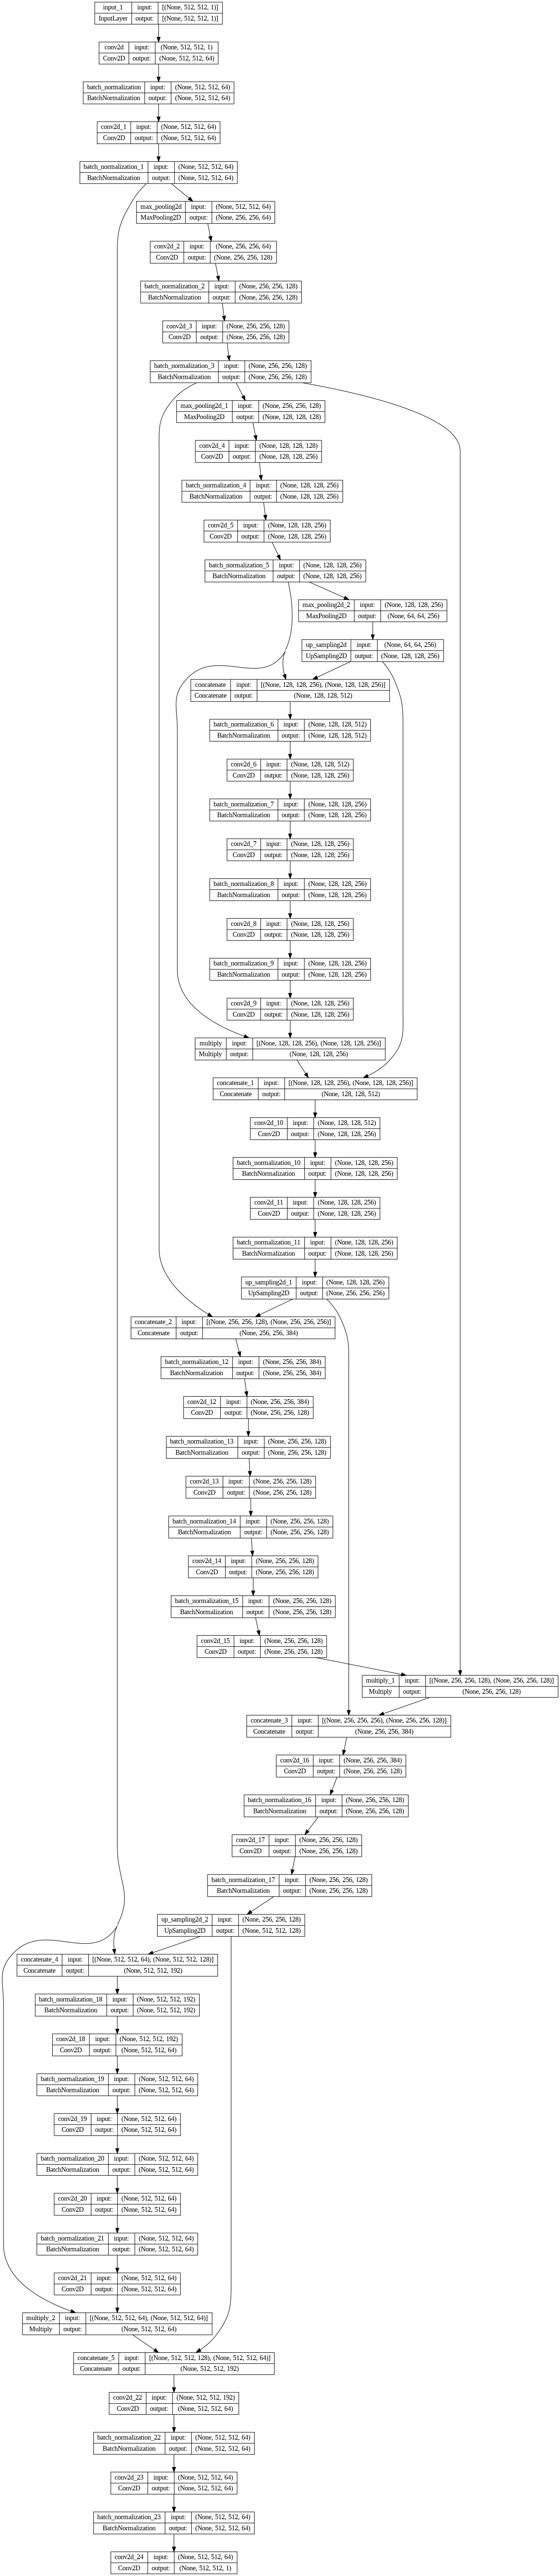

In [13]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [14]:
model.compile(optimizer='adam', loss=binary_crossentropy, metrics=['accuracy'])

In [15]:
history = model.fit(train_generator, steps_per_epoch=len(train_images), epochs=50, verbose = 1, validation_data=val_generator, validation_steps=len(val_images))

Epoch 1/50
24/24 [==============================] - 37s 412ms/step - loss: 0.4747 - accuracy: 0.7775 - val_loss: 0.5200 - val_accuracy: 0.7489
Epoch 2/50
24/24 [==============================] - 9s 365ms/step - loss: 0.3208 - accuracy: 0.8501 - val_loss: 0.5529 - val_accuracy: 0.7514
Epoch 3/50
24/24 [==============================] - 9s 391ms/step - loss: 0.2923 - accuracy: 0.8492 - val_loss: 0.8844 - val_accuracy: 0.7439
Epoch 4/50
24/24 [==============================] - 9s 372ms/step - loss: 0.2633 - accuracy: 0.8571 - val_loss: 0.6083 - val_accuracy: 0.7320
Epoch 5/50
24/24 [==============================] - 9s 373ms/step - loss: 0.2569 - accuracy: 0.8552 - val_loss: 0.5282 - val_accuracy: 0.7631
Epoch 6/50
24/24 [==============================] - 9s 375ms/step - loss: 0.2564 - accuracy: 0.8539 - val_loss: 0.6682 - val_accuracy: 0.7370
Epoch 7/50
24/24 [==============================] - 10s 400ms/step - loss: 0.2370 - accuracy: 0.8634 - val_loss: 0.6938 - val_accuracy: 0.7545
Epoc

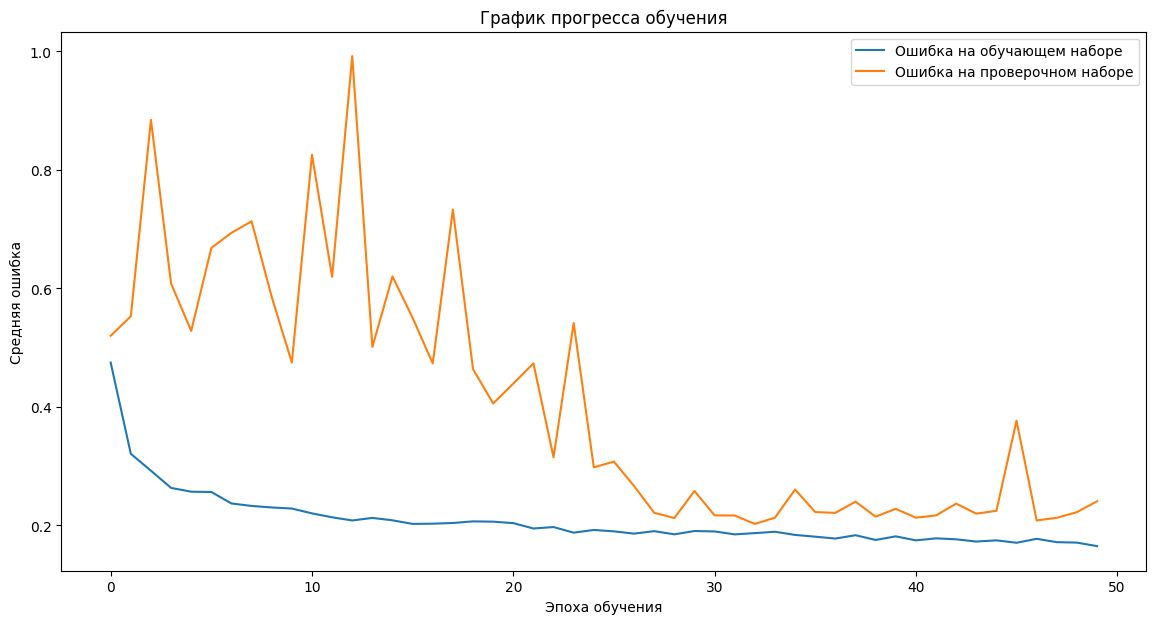

In [16]:
# Рисование графиков прошедшей фазы обучения
fig = plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.title(f'График прогресса обучения')
# Указание показывать только целые метки шкалы оси x
fig.gca().xaxis.get_major_locator().set_params(integer=True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

1/1 [==============================] - 9s 9s/step


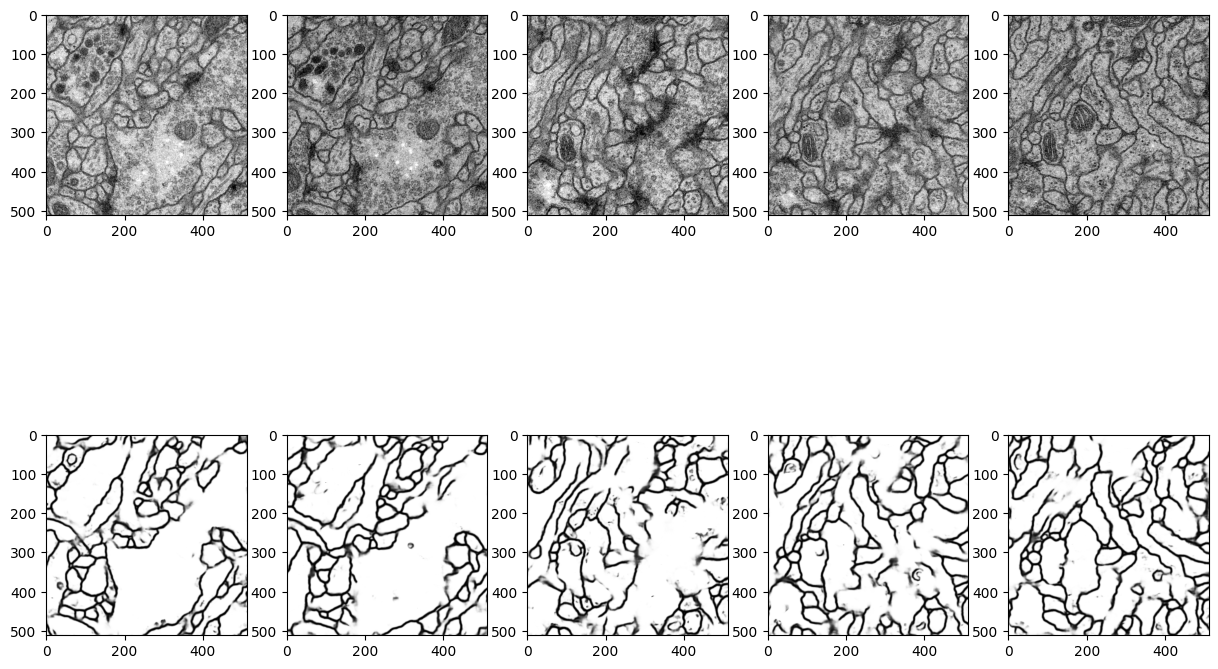

In [17]:
result = model.predict(test_images[0:5])                                        #  Предсказываем значения
fig = plt.figure(figsize=(15,10))                                               #  Создаем фигуру
for i in range(5):                                                              #  Цикл по колчеству картинку в пердсказнии
  plt.subplot(2, 5, i+1)                                                        #  Создаем subplot
  plt.imshow(test_images[i].reshape(512, 512), cmap='gray')                     #  Выводим изображения из теста
  plt.subplot(2, 5, i+6)                                                        #  Создаем subplot
  plt.imshow(result[i].reshape(512, 512), cmap='gray')                          #  Выводим предсказания для изображения теста